In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

# import sys
# sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
# from utils import 

    

In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [5]:
fnumber_old = 0

In [97]:
eddy = 170
t_idx = 224

df_eddy = df_eddies[df_eddies.Eddy==eddy]
day = df_eddy.iloc[t_idx].Day

r = 150
data = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies['Day']==day)].iloc[0]
fname = data.fname
fnumber = fname[-8:-3]
if fnumber != fnumber_old:

    u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
    v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
    
    u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
    
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == day)[0][0]

u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

xc_surf, yc_surf = data.xc, data.yc
ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
X_mask, Y_mask = np.meshgrid(x_mask, y_mask)

X, Y = X_grid[X_mask, Y_mask], Y_grid[X_mask, Y_mask]


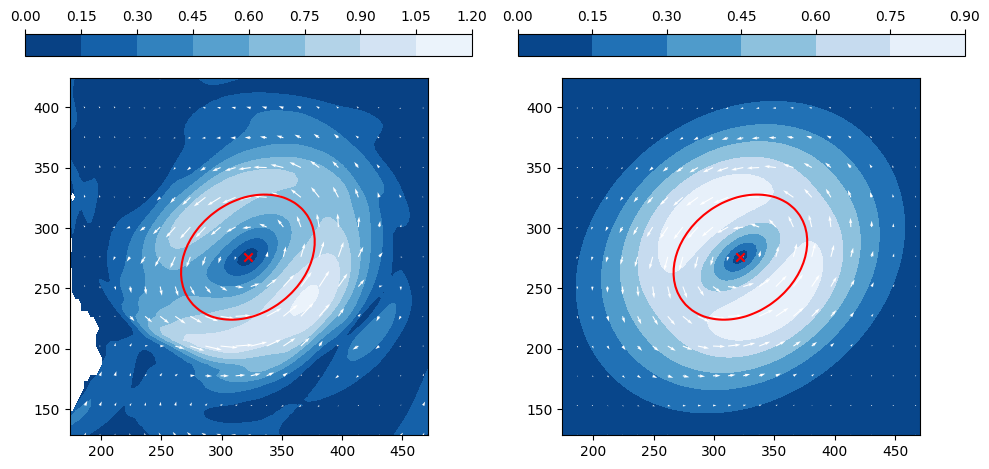

In [98]:
k = 0
utk, vtk = u_t[:, :, k], v_t[:, :, k]
utk, vtk = utk[X_mask, Y_mask], vtk[X_mask, Y_mask]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# ---- (1,1)
ax1 = ax[0]
cf = ax1.contourf(X, Y, np.hypot(utk, vtk), cmap='Blues_r')
fig.colorbar(cf, ax=ax1, location='top')
spac = 5
ax1.quiver(X[::spac, ::spac], Y[::spac, ::spac], utk[::spac, ::spac], vtk[::spac, ::spac],
           width=.003, scale=20, color='w')
ax1.scatter(data.xc, data.yc, marker='x', color='r')

dx_ell, dy_ell = X_grid - data.xc, Y_grid - data.yc
rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
ax1.contour(X_grid, Y_grid, rho2_ell, levels=[data.Rc**2/2], colors='r')

ax1.set_aspect('equal')
ax1.set_xlim(X.min(), X.max()); ax1.set_ylim(Y.min(), Y.max())

# ---- (1,2)
ax2 = ax[1]
dx, dy = X - data.xc, Y - data.yc
rho2 = data.q11*dx**2 + 2*data.q12*dx*dy + data.q22*dy**2

u = - data.A * np.exp(-rho2 / data.Rc**2) * (2*data.q12*dx + 2*data.q22*dy)
v =   data.A * np.exp(-rho2 / data.Rc**2) * (2*data.q11*dx + 2*data.q12*dy)

cf2 = ax2.contourf(X, Y, np.hypot(u, v), cmap='Blues_r')
fig.colorbar(cf2, ax=ax2, location='top')
ax2.quiver(X[::spac, ::spac], Y[::spac, ::spac], u[::spac, ::spac], v[::spac, ::spac],
           width=.003, scale=20, color='w')
ax2.scatter(data.xc, data.yc, marker='x', color='r')
ax2.contour(X_grid, Y_grid, rho2_ell, levels=[data.Rc**2/2], colors='r')
ax2.set_aspect('equal'); ax2.set_xlim(X.min(), X.max()); ax2.set_ylim(Y.min(), Y.max())

plt.tight_layout()
plt.show()
